In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

In [2]:
def __default_exclusion():
    return ['page_id', 'page', 'category', 'user', 'label','content_token_edit_count_avg', 'content_token_vs_stop_words']

def drop_columns_gm(columns):
    drop_list = __generalized_model_exclusion()
    drop_list.extend(columns)
    return drop_list    

def drop_columns_fm(columns):
    drop_list = __full_model_exclusion()
    drop_list.extend(columns)
    return drop_list

def __full_model_exclusion():
    return __default_exclusion()

def __generalized_model_exclusion():
    exclusion = __default_exclusion()
    exclusion.extend(['page_talk_edits',
                        'tenure',
                        'ns1_edit_dist',
                        'ns2_edit_dist',
                        'ns3_edit_dist',
                        'ns4_edit_dist',
                        'ns5_edit_dist',
                        'ns6_edit_dist',
                        'ns7_edit_dist',
                        'ns8_edit_dist',
                        'ns9_edit_dist',
                        'ns10_edit_dist',
                        'ns11_edit_dist',
                        'ns12_edit_dist',
                        'ns13_edit_dist',
                        'ns14_edit_dist',
                        'ns15_edit_dist',
                        'total_edited_pages'])

    
    return exclusion
    
def get_metrics(classifier, x, y, cv):
    results = cross_val_score(classifier, x, y, cv=cv)
    
    accuracy = results.mean()
    precision = cross_val_score(classifier, x, y, scoring='precision', cv=cv).mean()
    recall = cross_val_score(classifier, x, y, scoring='recall', cv=cv).mean()
    f1 = cross_val_score(classifier, x, y, scoring='f1', cv=cv).mean()
    roc_auc = cross_val_score(classifier, x, y, scoring='roc_auc', cv=cv).mean()

#     print(results)
#     print('Accuracy: %.3f%%' % accuracy)
#     print('Precision: %.3f%%' % precision) 
#     print('Recall: %.3f%%' % recall)
#     print('F1: %.3f%%' % f1)
#     print('ROC AUC: %.3f%%' % roc_auc)
#     print('\n')
    return [accuracy, precision, recall, f1, roc_auc]

# Ablation Study

In [3]:
# initializing params
columns = ['Ablation Category', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

# initializing ablation categories
baseline = []
demographics = ['gender']
focal_page_qty_co_prod = ['page_edits', 'page_edits_ratio', 'edit_period_q1', 'edit_period_q2', 'edit_period_q3', 'edit_period_q4', 'mean_edit_interval', 'mean_edit_size']
focal_page_nature_co_prod = ['content_token_count', 'edit_type_a', 'edit_type_b', 'edit_type_c', 'edit_type_d', 'edit_type_e', 'edit_type_f', 'edit_type_g', 'edit_type_h', 'edit_type_i', 'edit_type_j', 'edit_type_k', 'edit_type_l', 'edit_type_m', 'content_token_vs_token']
contribution_relevance = ['contribution_similarity']
focal_page_quality_co_prod = ['avg_persistence']
focal_page_coordination_qty = ['page_talk_edits']
activity_in_wiki_community = ['tenure', 'total_edited_pages', 'ns1_edit_dist', 'ns2_edit_dist', 'ns3_edit_dist', 'ns4_edit_dist', 'ns5_edit_dist', 'ns6_edit_dist', 'ns7_edit_dist', 'ns8_edit_dist', 'ns9_edit_dist', 'ns10_edit_dist', 'ns11_edit_dist', 'ns12_edit_dist', 'ns13_edit_dist', 'ns14_edit_dist', 'ns15_edit_dist']
topical_concetration = ['links_overlap', 'categories_overlap', 'title_similarity', 'summary_similarity']
overall_wiki_activity = ['page_edit_dist', 'ns0_edit_dist']

ablation_categories = {'*** All features ***': baseline,
                       'Demographics': demographics,
                       'Quantity of co-production activity within focal page': focal_page_qty_co_prod,
                       'Nature of co-production activity within focal page': focal_page_nature_co_prod,
                       'Relevance of one\'s contributions to the page\'s contents': contribution_relevance,
                       'Quality of co-production activity within focal page': focal_page_quality_co_prod,
                       'Quantity of coordination activity related to focal page': focal_page_coordination_qty,
                       'Nature of activity in Wikipedia community': activity_in_wiki_community,
                       'Topical concentration in co-production activity': topical_concetration,
                       'Overall activity in co-production Wikipedia community': overall_wiki_activity}

# loading data (training set)
df = pd.read_csv('data/new_train_data.csv', header=0)
print('Total experts: {}'.format(len(df[df.label == 1])))
print('Total non-experts: {}'.format(len(df[df.label == 0])))

Total experts: 506
Total non-experts: 514


In [4]:
df.drop(['edit_type_exists'], axis=1, inplace=True)
edit_types = [col for col in df.columns if str(col).startswith('edit_type')]
print(edit_types)
for edit_type in edit_types:
    df[edit_type].fillna(value=-1, inplace=True)  

['edit_type_a', 'edit_type_b', 'edit_type_c', 'edit_type_d', 'edit_type_e', 'edit_type_f', 'edit_type_g', 'edit_type_h', 'edit_type_i', 'edit_type_j', 'edit_type_k', 'edit_type_l', 'edit_type_m']


/home/yarov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: -0.492550 using {'learning_rate': 0.1, 'n_estimators': 160}
-0.690369 (0.000305) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.689820 (0.000366) with: {'learning_rate': 0.0001, 'n_estimators': 120}
-0.689273 (0.000426) with: {'learning_rate': 0.0001, 'n_estimators': 140}
-0.688728 (0.000486) with: {'learning_rate': 0.0001, 'n_estimators': 160}
-0.688186 (0.000546) with: {'learning_rate': 0.0001, 'n_estimators': 180}
-0.687646 (0.000606) with: {'learning_rate': 0.0001, 'n_estimators': 200}
-0.667594 (0.002966) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.663039 (0.003544) with: {'learning_rate': 0.001, 'n_estimators': 120}
-0.658674 (0.004110) with: {'learning_rate': 0.001, 'n_estimators': 140}
-0.654522 (0.004655) with: {'learning_rate': 0.001, 'n_estimators': 160}
-0.650556 (0.005173) with: {'learning_rate': 0.001, 'n_estimators': 180}
-0.646801 (0.005687) with: {'learning_rate': 0.001, 'n_estimators': 200}
-0.564424 (0.020444) with: {'learning_rate': 0.01, '

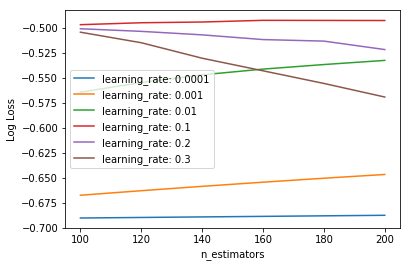

In [5]:
model = XGBClassifier()

n_estimators = [100, 120, 140, 160, 180, 200]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

X = df.drop(drop_columns_gm([]), axis=1)
y = df.label

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_learning_rate.png')

## Generalized model

In [5]:
gm_rows = []
for ablation_category in ablation_categories.keys():
    print('Ablation Category: ' + ablation_category)
    X = df.drop(drop_columns_gm(ablation_categories[ablation_category]), axis=1)
    print('Columns: {}\n'.format(list(X.columns)))
    y = df.label
    kfold = StratifiedKFold(n_splits=10, random_state=7)
    model = XGBClassifier(objective='binary:logistic', seed=123, n_estimators=160)
    metrics = get_metrics(classifier=model, x=X, y=y, cv=kfold)
    
    gm_row = [ablation_category]
    for metric in metrics:
        gm_row.append(metric)
    gm_rows.append(gm_row)

gm_df = pd.DataFrame(gm_rows, columns=columns)
gm_df.to_csv('data/new_ablation_study_gm.csv', index=False)

Ablation Category: Baseline
Columns: ['page_edits', 'page_edits_ratio', 'edit_period_q1', 'edit_period_q2', 'edit_period_q3', 'edit_period_q4', 'mean_edit_interval', 'mean_edit_size', 'gender', 'ns0_edit_dist', 'page_edit_dist', 'links_overlap', 'categories_overlap', 'title_similarity', 'summary_similarity', 'avg_persistence', 'content_token_count', 'content_token_vs_token', 'contribution_similarity', 'persistence_exists', 'edit_type_a', 'edit_type_b', 'edit_type_c', 'edit_type_d', 'edit_type_e', 'edit_type_f', 'edit_type_g', 'edit_type_h', 'edit_type_i', 'edit_type_j', 'edit_type_k', 'edit_type_l', 'edit_type_m']

Ablation Category: Demographics
Columns: ['page_edits', 'page_edits_ratio', 'edit_period_q1', 'edit_period_q2', 'edit_period_q3', 'edit_period_q4', 'mean_edit_interval', 'mean_edit_size', 'ns0_edit_dist', 'page_edit_dist', 'links_overlap', 'categories_overlap', 'title_similarity', 'summary_similarity', 'avg_persistence', 'content_token_count', 'content_token_vs_token', 'cont

## Full model

In [6]:
fm_rows = []
for ablation_category in ablation_categories.keys():
    print('Ablation Category: ' + ablation_category)
    X = df.drop(drop_columns_fm(ablation_categories[ablation_category]), axis=1)
    y = df.label
    kfold = StratifiedKFold(n_splits=10, random_state=7)
    model = XGBClassifier(objective='binary:logistic', seed=123, n_estimators=160)
    metrics = get_metrics(classifier=model, x=X, y=y, cv=kfold)
    
    fm_row = [ablation_category]
    for metric in metrics:
        fm_row.append(metric)
    fm_rows.append(fm_row)

fm_df = pd.DataFrame(fm_rows, columns=columns)
fm_df.to_csv('data/new_ablation_study_fm.csv', index=False)

Ablation Category: Baseline
Ablation Category: Demographics
Ablation Category: Quantity of co-production activity within focal page
Ablation Category: Nature of co-production activity within focal page
Ablation Category: Relevance of one's contributions to the page's contents
Ablation Category: Quality of co-production activity within focal page
Ablation Category: Quantity of coordination activity related to focal page
Ablation Category: Nature of activity in Wikipedia community
Ablation Category: Topical concentration in co-production activity
Ablation Category: Overall activity in co-production Wikipedia community
